In [6]:
from braket.ahs.atom_arrangement import AtomArrangement
import numpy as np
from quera_ahs_utils.plotting import show_register
import matplotlib.pyplot as plt
from itertools import product
from collections import Counter
from copy import deepcopy
from braket.aws import AwsDevice
import networkx as nx
import json

In [7]:
points = [
(-1.380625,0.923125),
(-1.190625,0.273125),
(-0.660625,-0.256875),
(-1.510625,-0.456875),
(-2.330625,-0.196875),
(-1.880625,0.343125),
(-2.620625,0.553125),
(0.169375,-0.616875),
(-0.050625,0.503125),
]

In [18]:
def points_to_unit_graph(atom_list, scale=1):
    """Populate the connections of a unit disk graph given a list of points

    Args:
        atom_list (list[tuple]): list of x,y coordinates.
        scale (int, optional): scale to use for unit distance. Defaults to 1.

    Returns:
        graph : graph generated from the x,y coords
    """
    edge_dict = {}
    for i in range(len(atom_list)):
        for j in range(len(atom_list)):
            if(j == i):
                continue
            if np.sqrt((atom_list[i][0]-atom_list[j][0])**2 + (atom_list[i][1]-atom_list[j][1])**2) <= scale:
                if(i in edge_dict):
                    edge_dict[i].append(j)
                else:
                    edge_dict[i] = [j]
    return nx.from_dict_of_lists(edge_dict)

def plot_graph(point_list, plot = True):
    """Method to generate AtomArrangement from a list of points

    Args:
        point_list (tuple) : a list of x and y coordinates in units of 1e-6

    Returns:
        graph
    """
    atoms = AtomArrangement()
    for atom in points:
        atoms.add(atom)
    graph = points_to_unit_graph(scale=1, atom_list=point_list)

    if plot:
        fig, ax = plt.subplots()
        pos = {ii: (point_list[ii][0],point_list[ii][1]) for ii in graph.nodes()}

        nx.draw(graph, pos=pos, with_labels=True)
        plt.show()
    return graph

In [19]:
def find_UDG_radius(position, graph):
    """Code borrowed from 'Maximum Independent Sets with Analog Hamiltonian Simulation'

    Args:
        position (list[tuple]): a list of x,y coordinates of points
        graph (Graph): the unit graph representation of the coordinates

    Raises:
        Exception: If a graph created with the graph maker program is not a unit disk graph,
        then something has gone horribly wrong!

    Returns:
        tuple[int]: The geometric mean, the min, and the max radius
    """
    
    dists = [[np.sqrt((x0-x1)**2+(y0-y1)**2) for (x0,y0) in position] for (x1,y1) in position]
    rmin = 0
    rmax = np.inf
    for i in range(len(position)):
        for j in range(i+1,len(position)):
            if (i,j) in graph.edges:
                if rmin<dists[i][j]:
                    rmin = dists[i][j]
            elif (i,j) not in graph.edges:
                if rmax>dists[i][j]:
                    rmax = dists[i][j]
    
    if rmin>rmax:
        print(rmin,rmax)
        raise BaseException("Graph is not a unit disk graph!")
    
    return np.sqrt(rmin*rmax),rmin,rmax

# Find unit disk radius
graph = plot_graph(points, plot = False)

In [20]:
unitdisk_radius,min_radius,max_radius = find_UDG_radius(points,graph)
unitdisk_radius

1.0546686746847045

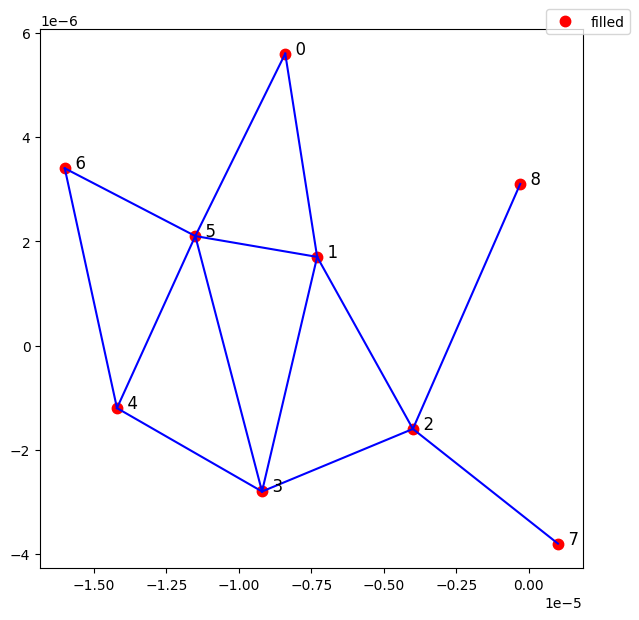

In [21]:
a = 6.1e-6
# Generate the atom register
from braket.ahs.atom_arrangement import AtomArrangement
register = AtomArrangement()
for (x,y) in points:
    register.add([round(a * x, 7),round(a*y,7)])
    
show_register(register, blockade_radius = a)

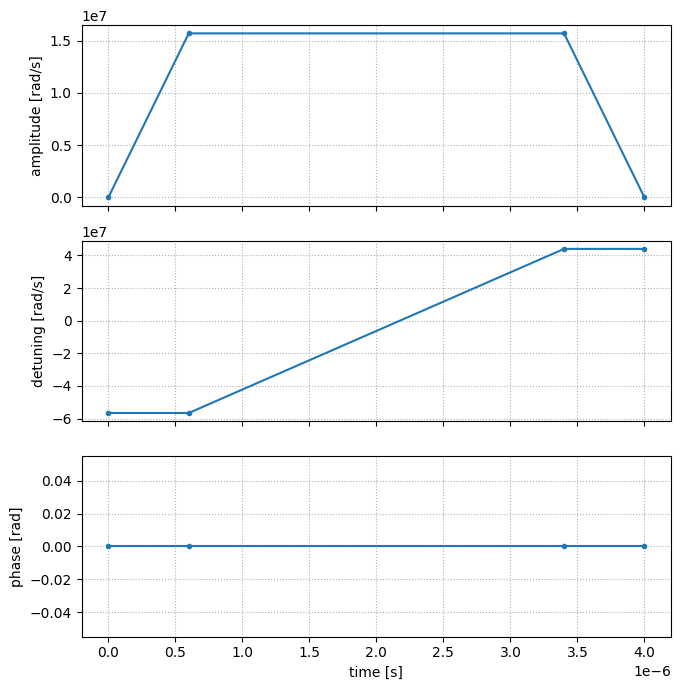

In [22]:
from braket.ahs.hamiltonian import Hamiltonian

H = Hamiltonian()

from quera_ahs_utils.plotting import show_global_drive 
from quera_ahs_utils.drive import get_drive

omega_min = 0       
omega_max = 2.5e6 * 2 * np.pi
detuning_min = -9e6 * 2 * np.pi
detuning_max = 7e6 * 2 * np.pi

time_max = 4e-6
time_ramp = 0.15*time_max

time_points = [0, time_ramp, time_max - time_ramp, time_max]
omega_values = [omega_min, omega_max, omega_max, omega_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 0, 0, 0]

drive = get_drive(time_points, omega_values, detuning_values, phase_values)
H += drive

show_global_drive(drive)
plt.show()

### Defining the program (1D case)

In [23]:
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=H
)

In [24]:
def save_result_json(json_file,result):
    '''
    Helper function to save results locally
    '''
    result_dict = {"measurements":[]}
    for measurement in result.measurements:
        shot_result = {
            "pre_sequence":[int(qubit) for qubit in measurement.pre_sequence],
            "post_sequence":[int(qubit) for qubit in measurement.post_sequence]
                      } 
        result_dict["measurements"].append(shot_result)
        
    with open(json_file,"w") as io:
        json.dump(result_dict,io,indent=2)

### Simulation on classical hardware

In [25]:
from braket.devices import LocalSimulator
classical_device = LocalSimulator("braket_ahs")

nshots = 20
task = classical_device.run(ahs_program, shots=nshots)

# The result can be downloaded directly into an object in the python session:
result = task.result()

In [26]:
def check_graph(graph_dict):
    for vertex in graph_dict:
        # Check for ground state atoms that could be Rydberg
        if(graph_dict[vertex][0] == 1):
            fail = True
            for a in graph_dict[vertex][1]:
                if(graph_dict[a][0] == 0):
                    fail = False
            if(fail):
                # print("DEATH")
                return False
            
        # Check for adjacent Rydberg atoms
        elif(graph_dict[vertex][0] == 0):
            # print(graph_dict[vertex])
            for a in graph_dict[vertex][1]:
                if(graph_dict[a][0] == 0):
                    # print("DEATH")
                    return False
    return True

def postprocessing(graph_dict):
    if(check_graph(graph_dict)):
        return graph_dict
    for vertex in graph_dict:
        # Check for adjacent Rydberg atoms and set them both to ground
        if(graph_dict[vertex][0] == 0):
            for a in graph_dict[vertex][1]:
                if(graph_dict[a][0] == 0):
                    graph_dict[vertex][0] = 1
                    graph_dict[a][0] = 1
                    break
    available_vertices = []
    for vertex in graph_dict:    
        if(graph_dict[vertex][0] == 1):
            available = True
            for a in graph_dict[vertex][1]:
                if(graph_dict[a][0] == 0):
                    available = False
            if(available):
                available_vertices.append(vertex)
                
    # Discard sufficienly bad graphs that become computationally intractable
    if(len(available_vertices) > 10):
        print("Intractable")
        return None
    
    for bits in product([0,1], repeat=len(available_vertices)):
        test_graph = graph_dict
        for vertex in range(len(available_vertices)):
            test_graph[available_vertices[vertex]][0] = bits[vertex]
        if(check_graph(test_graph)):
            return test_graph
        # else:
            # print(test_graph)
        # print(test_graph)

    return None

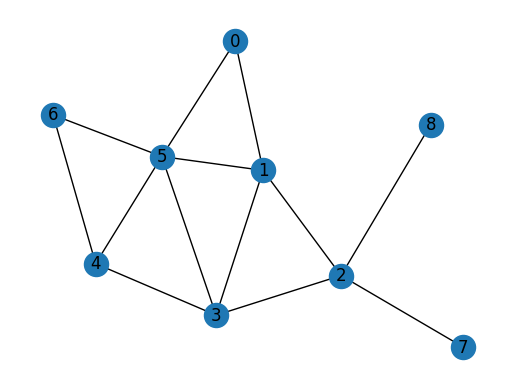

In [27]:
graph = plot_graph(points);

In [28]:
i = 0
post_process_result = deepcopy(result)
# print(final_registers.measurements)
bad_measurements = []
for shot in post_process_result.measurements:
    colored_graph = nx.to_dict_of_dicts(graph)
    for s in range(len(shot.post_sequence)): 
        colored_graph[s] = [shot.post_sequence[s] if shot.pre_sequence[s] == 1 else 2 ,colored_graph[s]]
    clean_graph = postprocessing(colored_graph)
    if(clean_graph == None):
        bad_measurements.append(i)
    else:
        for vertex in clean_graph:
            post_process_result.measurements[i].post_sequence[vertex] = clean_graph[vertex][0]
    i = i+1

In [29]:
final_results = []
for i,result in enumerate(post_process_result.measurements):
    if not i in bad_measurements:
        final_results.append(result)

Independent set of 0-th most likely outcome


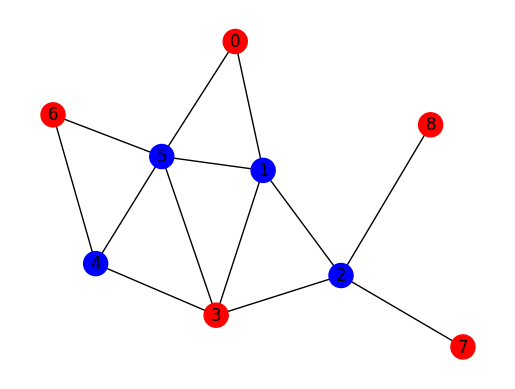

In [30]:
states = ['e', 'r', 'g']
state_labels = []
for shot in final_results:
    pre = shot.pre_sequence
    post = shot.post_sequence
    state_idx = np.array(pre) * (1 + np.array(post))
    state_labels.append("".join([states[s_idx] for s_idx in state_idx]))

occurence_count = Counter(state_labels)

most_frequent_regs = occurence_count.most_common(5)

most_frequent_regs = occurence_count.most_common(5)
for ii in range(len(most_frequent_regs)):
    fig, ax = plt.subplots()
    vert_colors = ['red' if (most_frequent_regs[ii][0][i] == 'r') else 'blue' for i in range(len(most_frequent_regs[ii][0]))]
    print(f'Independent set of {ii}-th most likely outcome')
    nx.draw(graph, pos = {ii: points[ii] for ii in graph.nodes()}, ax=ax, with_labels=True, node_color=vert_colors)
    plt.show()

In [31]:
occurence_count

Counter({'rggrggrrr': 20})